In [1]:
import pandas as pd # Importing pandas library for data analysis
import numpy as np  # Importing numpy library for numerical computing
import seaborn as sns # Importing seaborn library for data visualization
import matplotlib
import matplotlib.pyplot as plt # Importing matplotlib library for data visualization

sns.set_context('notebook') # Setting the seaborn context for notebook style plots
sns.set_style('whitegrid') # Setting the seaborn style to whitegrid
sns.set_palette('Spectral') # Setting the seaborn color palette to Spectral

import warnings # Importing the warnings library to ignore any warning messages during analysis
warnings.filterwarnings('ignore')

# Finance related operations
from pandas_datareader import data

# Import this to silence a warning when converting data column of a dataframe on the fly
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
import statsmodels.api as sm

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
data5 = pd.concat([pd.read_csv("2014_Financial_Data.csv"),
                    pd.read_csv("2015_Financial_Data.csv"),
                    pd.read_csv("2016_Financial_Data.csv"),
                    pd.read_csv("2017_Financial_Data.csv"),
                    pd.read_csv("2018_Financial_Data.csv"),],sort=False).drop_duplicates().sample(frac=1)
data5 = data5.rename(columns={'Unnamed: 0': 'Ticker'})
print(data5.shape)
data5.head()

(22077, 229)


,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class,2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%]
2726,CRR,1.030510e+08,-0.6314,188065000.0,-85014000.0,0.0,39984000.0,40888000.0,-125902000.0,5435000.0,...,-0.1298,0.0000,-0.3572,Energy,NaN,0,NaN,-6.088559,NaN,NaN
862,ATOS,4.013800e+04,-0.9365,0.0,40138.0,1110329.0,8748211.0,12211166.0,-12171028.0,0.0,...,-1.0000,0.0047,-0.1088,Healthcare,-77.142858,0,NaN,NaN,NaN,NaN
1676,ESS,1.400053e+09,0.0265,416396000.0,983657000.0,0.0,53451000.0,533529000.0,450128000.0,220492000.0,...,-0.0146,0.0000,0.2916,Real Estate,NaN,1,NaN,NaN,NaN,30.508058
3344,KFS,1.582240e+08,-0.0816,113345000.0,40337000.0,0.0,41613000.0,41865000.0,-1528000.0,5278000.0,...,-0.0506,0.0000,-0.4786,Financial Services,NaN,1,37.969089,NaN,NaN,NaN
2653,NOG,1.449035e+08,-0.4732,61193718.0,83709778.0,0.0,14757641.0,313014633.0,-229304855.0,64485623.0,...,0.0109,0.0000,-0.2250,Energy,NaN,0,NaN,-29.310349,NaN,NaN


In [4]:
data5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 2726 to 2538
Columns: 229 entries, Ticker to 2019 PRICE VAR [%]
dtypes: float64(226), int64(1), object(2)
memory usage: 38.7+ MB


In [5]:
# Tetapkan kolom 'Ticker' sebagai indeks DataFrame
# data5 = data5.set_index('Unnamed: 0')

# Ubah kolom 'Sector' menjadi variabel kategori dengan menggantinya dengan kode numerik yang sesuai
# data5['Sector'] = data5['Sector'].astype('category').cat.codes

# Gantikan nilai NaN dengan 0
data5.fillna(0, inplace=True)



In [6]:
# Assuming data5 is the concatenated DataFrame
data_filled = data5.replace(0, np.nan)  # Replace 0 with NaN temporarily

# Calculate the percentage of non-zero values for each company
data_filled['non_zero_percentage'] = data_filled.apply(lambda x: x.count() / len(x) * 100, axis=1)

# Calculate the quartiles for non_zero_percentage
q1 = data_filled['non_zero_percentage'].quantile(0.25)
q2 = data_filled['non_zero_percentage'].quantile(0.5)
q3 = data_filled['non_zero_percentage'].quantile(0.75)

print("Q1:", q1)
print("Q2 (Median):", q2)
print("Q3:", q3)

# Set the threshold for retaining or removing companies
threshold = q1  # Example: You may choose Q1 as the threshold

# Filter the dataset based on the threshold
data_cleaned = data_filled[data_filled['non_zero_percentage'] >= threshold]

# Replace NaN back to 0
data_cleaned = data_cleaned.fillna(0)

Q1: 68.5589519650655
Q2 (Median): 77.72925764192141
Q3: 84.71615720524017


In [7]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16608 entries, 2726 to 2538
Columns: 230 entries, Ticker to non_zero_percentage
dtypes: float64(228), object(2)
memory usage: 29.3+ MB


In [8]:
average_indicators_filled = 229 * 0.7772925764192141
print(average_indicators_filled)


178.00000000000003


In [9]:
data_cleaned.head()

,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class,2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%],non_zero_percentage
2726,CRR,1.030510e+08,-0.6314,188065000.0,-85014000.0,0.0,39984000.0,40888000.0,-125902000.0,5435000.0,...,0.0000,-0.3572,Energy,0.0,0.0,0.000000,-6.088559,0.0,0.000000,78.602620
1676,ESS,1.400053e+09,0.0265,416396000.0,983657000.0,0.0,53451000.0,533529000.0,450128000.0,220492000.0,...,0.0000,0.2916,Real Estate,0.0,1.0,0.000000,0.000000,0.0,30.508058,83.842795
3344,KFS,1.582240e+08,-0.0816,113345000.0,40337000.0,0.0,41613000.0,41865000.0,-1528000.0,5278000.0,...,0.0000,-0.4786,Financial Services,0.0,1.0,37.969089,0.000000,0.0,0.000000,75.109170
2653,NOG,1.449035e+08,-0.4732,61193718.0,83709778.0,0.0,14757641.0,313014633.0,-229304855.0,64485623.0,...,0.0000,-0.2250,Energy,0.0,0.0,0.000000,-29.310349,0.0,0.000000,71.179039
3298,UTMD,4.199800e+07,0.0141,15692000.0,26306000.0,454000.0,7155000.0,7609000.0,18697000.0,0.0,...,0.0157,0.0314,Healthcare,0.0,1.0,0.000000,0.000000,0.0,28.838006,84.279476


In [10]:
data_cleaned.drop('Class', axis=1, inplace=True)
data_cleaned

,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%],non_zero_percentage
2726,CRR,1.030510e+08,-0.6314,1.880650e+08,-8.501400e+07,0.0,3.998400e+07,4.088800e+07,-1.259020e+08,5435000.0,...,-0.1298,0.0000,-0.3572,Energy,0.0,0.000000,-6.088559,0.0,0.000000,78.602620
1676,ESS,1.400053e+09,0.0265,4.163960e+08,9.836570e+08,0.0,5.345100e+07,5.335290e+08,4.501280e+08,220492000.0,...,-0.0146,0.0000,0.2916,Real Estate,0.0,0.000000,0.000000,0.0,30.508058,83.842795
3344,KFS,1.582240e+08,-0.0816,1.133450e+08,4.033700e+07,0.0,4.161300e+07,4.186500e+07,-1.528000e+06,5278000.0,...,-0.0506,0.0000,-0.4786,Financial Services,0.0,37.969089,0.000000,0.0,0.000000,75.109170
2653,NOG,1.449035e+08,-0.4732,6.119372e+07,8.370978e+07,0.0,1.475764e+07,3.130146e+08,-2.293049e+08,64485623.0,...,0.0109,0.0000,-0.2250,Energy,0.0,0.000000,-29.310349,0.0,0.000000,71.179039
3298,UTMD,4.199800e+07,0.0141,1.569200e+07,2.630600e+07,454000.0,7.155000e+06,7.609000e+06,1.869700e+07,0.0,...,0.0000,0.0157,0.0314,Healthcare,0.0,0.000000,0.000000,0.0,28.838006,84.279476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,AOBC,5.518620e+08,-0.1193,3.569360e+08,1.949260e+08,6943000.0,9.835500e+07,1.052980e+08,8.962800e+07,10935000.0,...,0.7093,0.2293,-0.0401,Industrials,0.0,-9.450175,0.000000,0.0,0.000000,87.772926
2042,SWM,1.041300e+09,0.0603,7.628000e+08,2.785000e+08,15200000.0,1.266000e+08,1.435000e+08,1.350000e+08,28200000.0,...,-0.0908,-0.1461,-0.0201,Basic Materials,0.0,0.000000,0.000000,0.0,72.801621,93.449782
3159,PFBI,4.805400e+07,0.0036,0.000000e+00,4.805400e+07,0.0,2.654500e+07,3.369500e+07,1.435900e+07,0.0,...,0.2082,0.0000,-0.0220,Financial Services,0.0,28.125010,0.000000,0.0,0.000000,75.982533
414,GEVO,3.013700e+07,0.0662,3.876200e+07,-8.625000e+06,6610000.0,1.669200e+07,2.330200e+07,-3.192700e+07,8243000.0,...,-0.0883,-0.5319,-0.0899,Basic Materials,0.0,-73.846154,0.000000,0.0,0.000000,74.235808


In [11]:
data_cleaned.sort_values('Ticker', ascending=True)


,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],2016 PRICE VAR [%],2017 PRICE VAR [%],2018 PRICE VAR [%],2019 PRICE VAR [%],non_zero_percentage
524,A,4.202000e+09,0.0406,2.005000e+09,2.197000e+09,329000000.0,1.253000e+09,1.582000e+09,615000000.0,72000000.0,...,0.1505,-0.0030,0.0538,Healthcare,0.000000,0.000000,45.350940,0.000000,0.000000,92.139738
492,A,4.038000e+09,-0.0025,1.997000e+09,2.041000e+09,330000000.0,1.189000e+09,1.519000e+09,522000000.0,66000000.0,...,-0.0048,-0.0782,-0.0083,Healthcare,0.000000,13.194947,0.000000,0.000000,0.000000,92.139738
460,A,4.048000e+09,0.0395,2.072000e+09,1.976000e+09,358000000.0,1.199000e+09,1.557000e+09,419000000.0,110000000.0,...,-0.3838,0.0623,0.0127,Healthcare,4.179246,0.000000,0.000000,0.000000,0.000000,92.139738
557,A,4.914000e+09,0.0988,2.227000e+09,2.687000e+09,385000000.0,1.374000e+09,1.759000e+09,928000000.0,75000000.0,...,-0.1054,0.1357,0.1180,Healthcare,0.000000,0.000000,0.000000,0.000000,30.976102,93.013100
536,A,4.472000e+09,0.0643,2.063000e+09,2.409000e+09,339000000.0,1.229000e+09,1.568000e+09,841000000.0,79000000.0,...,0.0562,0.0304,-0.0192,Healthcare,0.000000,0.000000,0.000000,0.717881,0.000000,93.449782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,ZUMZ,7.243370e+08,0.0821,4.625770e+08,2.617600e+08,0.0,1.889180e+08,1.889180e+08,72842000.0,0.0,...,-0.3227,0.0000,0.0936,Consumer Cyclical,-60.429206,0.000000,0.000000,0.000000,0.000000,83.842795
1638,ZUMZ,9.274010e+08,0.1090,6.175270e+08,3.098740e+08,0.0,2.611140e+08,2.611140e+08,48760000.0,0.0,...,0.0000,0.0000,0.1099,Consumer Cyclical,0.000000,0.000000,0.000000,0.000000,76.044849,80.349345
4391,ZYME,5.301900e+07,0.0243,0.000000e+00,5.301900e+07,56684000.0,2.945700e+07,8.614600e+07,-33127000.0,166000.0,...,0.0000,0.3577,0.5880,Healthcare,0.000000,0.000000,0.000000,0.000000,209.462222,70.742358
1198,ZYME,5.176200e+07,3.7018,0.000000e+00,5.176200e+07,41749000.0,1.855000e+07,6.076000e+07,-8998000.0,422000.0,...,-1.0000,0.1340,0.4776,Healthcare,0.000000,0.000000,0.000000,85.049794,0.000000,69.432314


In [12]:
# Define a function to set the class value based on the stock price gain
def set_class(value):
    if value >= 0:
        return 1
    else:
        return 0

# Iterate through the years and create new class columns
for year in range(2015, 2020):
    price_var_col = f'{year} PRICE VAR [%]'
    class_col = f'Class{year % 2000}'

    # Apply the set_class function to each value in the price_var_col
    data_cleaned[class_col] = data_cleaned[price_var_col].apply(set_class)

# Rearrange columns to put the class columns next to the corresponding price var columns
new_column_order = []
for year in range(2015, 2020):
    new_column_order.append(f'{year} PRICE VAR [%]')
    new_column_order.append(f'Class{year % 2000}')

remaining_columns = [col for col in data_cleaned.columns if col not in new_column_order]
new_column_order.extend(remaining_columns)

data_cleaned = data_cleaned[new_column_order]


In [13]:
data_cleaned.head(20)

,2015 PRICE VAR [%],Class15,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,non_zero_percentage
2726,0.000000,1,0.000000,1,-6.088559,0,0.000000,1,0.000000,1,...,-1.0000,-0.5139,-0.0706,-0.1350,-0.1691,-0.1298,0.0000,-0.3572,Energy,78.602620
1676,0.000000,1,0.000000,1,0.000000,1,0.000000,1,30.508058,1,...,0.0891,-0.2876,0.0000,-0.0090,-0.0048,-0.0146,0.0000,0.2916,Real Estate,83.842795
3344,0.000000,1,37.969089,1,0.000000,1,0.000000,1,0.000000,1,...,-0.4046,-0.1408,0.0000,-0.2012,-0.1436,-0.0506,0.0000,-0.4786,Financial Services,75.109170
2653,0.000000,1,0.000000,1,-29.310349,0,0.000000,1,0.000000,1,...,0.0000,-0.3033,0.0000,-0.4018,-1.4457,0.0109,0.0000,-0.2250,Energy,71.179039
3298,0.000000,1,0.000000,1,0.000000,1,0.000000,1,28.838006,1,...,0.0191,0.0919,0.0320,0.0757,0.1350,0.0000,0.0157,0.0314,Healthcare,84.279476
1791,0.000000,1,0.000000,1,0.000000,1,-1.336896,0,0.000000,1,...,0.0858,0.2163,0.1006,0.0905,0.0873,0.0641,0.0000,0.0969,Industrials,90.393013
1283,116.000004,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,...,0.0000,0.4115,0.0000,0.0269,0.5371,-0.4097,0.0000,0.0187,Consumer Cyclical,78.602620
1245,0.000000,1,0.000000,1,0.206000,1,0.000000,1,0.000000,1,...,0.2337,0.0000,0.0610,0.0725,0.0640,0.7934,0.0000,0.1019,Consumer Cyclical,88.209607
2495,0.000000,1,0.000000,1,0.000000,1,-1.538034,0,0.000000,1,...,-0.1064,-0.4154,0.0000,0.3204,-0.0691,0.3194,0.0000,0.0713,Real Estate,69.868996
417,0.000000,1,0.000000,1,30.906807,1,0.000000,1,0.000000,1,...,0.0000,-0.1078,0.1857,0.2454,0.1391,0.7695,0.0000,-0.0471,Basic Materials,71.179039


In [14]:
# Get the current column order
current_column_order = data_cleaned.columns.tolist()

# Create a list of the 'PRICE VAR [%]' and 'Class' columns to move
columns_to_move = []
for year in range(2015, 2020):
    columns_to_move.append(f'{year} PRICE VAR [%]')
    columns_to_move.append(f'Class{year % 2000}')

# Remove the 'PRICE VAR [%]' and 'Class' columns from the current column order
remaining_columns = [col for col in current_column_order if col not in columns_to_move]

# Create a new column order with the 'PRICE VAR [%]' and 'Class' columns at the rightmost side
new_column_order = remaining_columns + columns_to_move

# Reorder the DataFrame columns based on the new column order
data_cleaned = data_cleaned[new_column_order]

In [15]:
data_cleaned.head()

,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,2015 PRICE VAR [%],Class15,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19
2726,CRR,1.030510e+08,-0.6314,188065000.0,-85014000.0,0.0,39984000.0,40888000.0,-125902000.0,5435000.0,...,0.0,1,0.000000,1,-6.088559,0,0.0,1,0.000000,1
1676,ESS,1.400053e+09,0.0265,416396000.0,983657000.0,0.0,53451000.0,533529000.0,450128000.0,220492000.0,...,0.0,1,0.000000,1,0.000000,1,0.0,1,30.508058,1
3344,KFS,1.582240e+08,-0.0816,113345000.0,40337000.0,0.0,41613000.0,41865000.0,-1528000.0,5278000.0,...,0.0,1,37.969089,1,0.000000,1,0.0,1,0.000000,1
2653,NOG,1.449035e+08,-0.4732,61193718.0,83709778.0,0.0,14757641.0,313014633.0,-229304855.0,64485623.0,...,0.0,1,0.000000,1,-29.310349,0,0.0,1,0.000000,1
3298,UTMD,4.199800e+07,0.0141,15692000.0,26306000.0,454000.0,7155000.0,7609000.0,18697000.0,0.0,...,0.0,1,0.000000,1,0.000000,1,0.0,1,28.838006,1


In [16]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16608 entries, 2726 to 2538
Columns: 234 entries, Ticker to Class19
dtypes: float64(227), int64(5), object(2)
memory usage: 29.8+ MB


In [17]:
data_selected = data_cleaned

# Replace 0 values with NaN
data_selected.replace(0, np.nan, inplace=True)

# Group by Ticker and Sector, then calculate the mean of non-NaN values for each year
average_data = data_selected.groupby(['Ticker', 'Sector']).mean()

# Reset the index to make 'Ticker' and 'Sector' columns again
average_data.reset_index(inplace=True)


In [18]:
average_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3769 entries, 0 to 3768
Columns: 234 entries, Ticker to Class19
dtypes: float64(232), object(2)
memory usage: 6.7+ MB


In [19]:
average_data.head()

,Ticker,Sector,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,2015 PRICE VAR [%],Class15,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19
0,A,Healthcare,4.334800e+09,0.04814,2.072800e+09,2.262000e+09,348200000.0,1.248800e+09,1.597000e+09,6.650000e+08,...,4.179246,1.0,13.194947,1.0,45.350940,1.0,0.717881,1.0,30.976102,1.0
1,AA,Basic Materials,1.139300e+10,0.02115,8.997000e+09,2.396000e+09,41250000.0,3.092500e+08,1.647000e+09,7.490000e+08,...,NaN,1.0,22.046441,1.0,86.853968,1.0,-51.821641,1.0,-18.025913,1.0
2,AAL,Industrials,4.218900e+10,0.12840,1.863500e+10,2.355400e+10,NaN,1.209240e+10,1.907400e+10,4.480000e+09,...,-20.768098,1.0,15.404948,1.0,13.344850,1.0,-38.817936,1.0,-10.602069,1.0
3,AAME,Financial Services,1.730004e+08,0.02386,1.121842e+08,6.081620e+07,NaN,4.228860e+07,5.544040e+07,5.375800e+06,...,24.445114,1.0,-14.942088,1.0,-16.654341,1.0,-25.389821,1.0,-20.250605,1.0
4,AAN,Industrials,3.259027e+09,0.11624,2.951072e+08,2.963920e+09,NaN,1.392605e+09,2.730039e+09,2.338810e+08,...,-26.649795,1.0,41.604419,1.0,25.314724,1.0,6.825130,1.0,31.675678,1.0


In [20]:
from scipy import stats

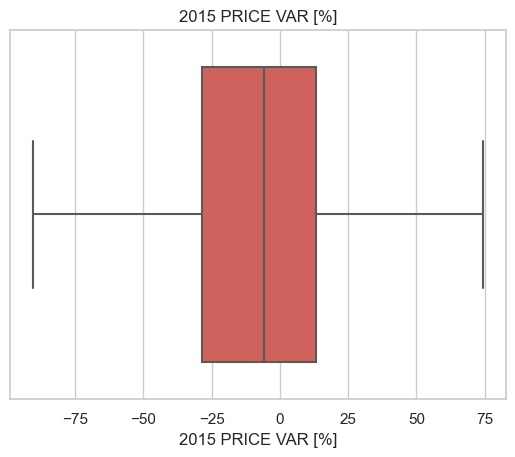

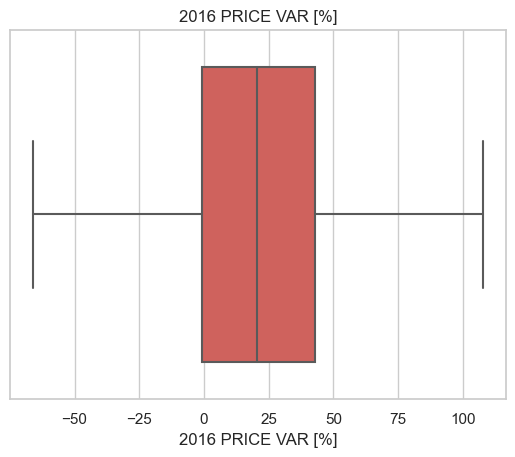

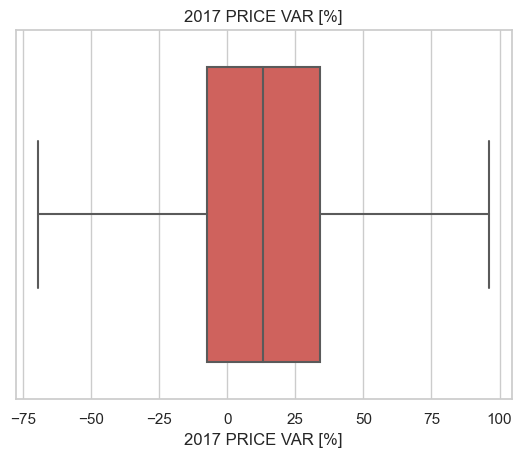

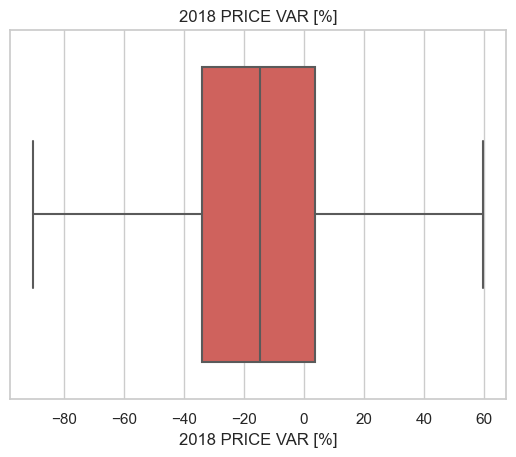

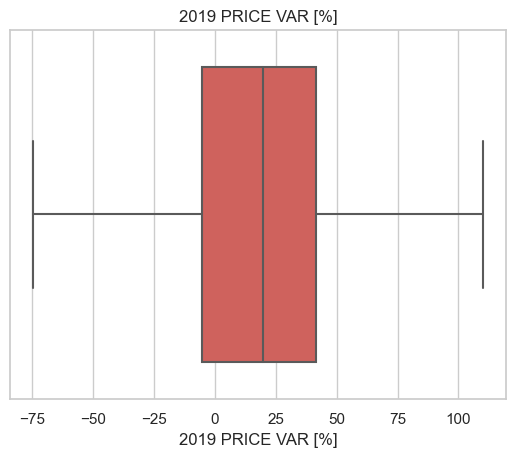

In [21]:
# Define the columns of interest
columns_of_interest = ['2015 PRICE VAR [%]', '2016 PRICE VAR [%]', '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]']

# Create a box plot for each column with showfliers=False
for column in columns_of_interest:
    sns.boxplot(x=average_data[column], showfliers=False)
    plt.title(column)
    plt.show()

# Calculate the interquartile range (IQR) for each column and store the outlier bounds
outlier_bounds = {}
for column in columns_of_interest:
    Q1 = average_data[column].quantile(0.25)
    Q3 = average_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_bounds[column] = (lower_bound, upper_bound)

# Create a new DataFrame without the outliers
average_data_no_outliers = average_data.copy()
for column in columns_of_interest:
    lower_bound, upper_bound = outlier_bounds[column]
    average_data_no_outliers = average_data_no_outliers[(average_data_no_outliers[column] >= lower_bound) & (average_data_no_outliers[column] <= upper_bound)]


In [22]:
average_data_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 0 to 3767
Columns: 234 entries, Ticker to Class19
dtypes: float64(232), object(2)
memory usage: 3.9+ MB


In [23]:
average_data_no_outliers.head()

,Ticker,Sector,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,2015 PRICE VAR [%],Class15,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19
0,A,Healthcare,4.334800e+09,0.04814,2.072800e+09,2.262000e+09,348200000.0,1.248800e+09,1.597000e+09,6.650000e+08,...,4.179246,1.0,13.194947,1.0,45.350940,1.0,0.717881,1.0,30.976102,1.0
2,AAL,Industrials,4.218900e+10,0.12840,1.863500e+10,2.355400e+10,NaN,1.209240e+10,1.907400e+10,4.480000e+09,...,-20.768098,1.0,15.404948,1.0,13.344850,1.0,-38.817936,1.0,-10.602069,1.0
3,AAME,Financial Services,1.730004e+08,0.02386,1.121842e+08,6.081620e+07,NaN,4.228860e+07,5.544040e+07,5.375800e+06,...,24.445114,1.0,-14.942088,1.0,-16.654341,1.0,-25.389821,1.0,-20.250605,1.0
4,AAN,Industrials,3.259027e+09,0.11624,2.951072e+08,2.963920e+09,NaN,1.392605e+09,2.730039e+09,2.338810e+08,...,-26.649795,1.0,41.604419,1.0,25.314724,1.0,6.825130,1.0,31.675678,1.0
5,AAOI,Technology,2.461718e+08,0.33164,1.570306e+08,8.914120e+07,30774000.0,3.480920e+07,6.558320e+07,2.355800e+07,...,59.036144,1.0,43.891953,1.0,63.722940,1.0,-59.298337,1.0,-25.188917,1.0


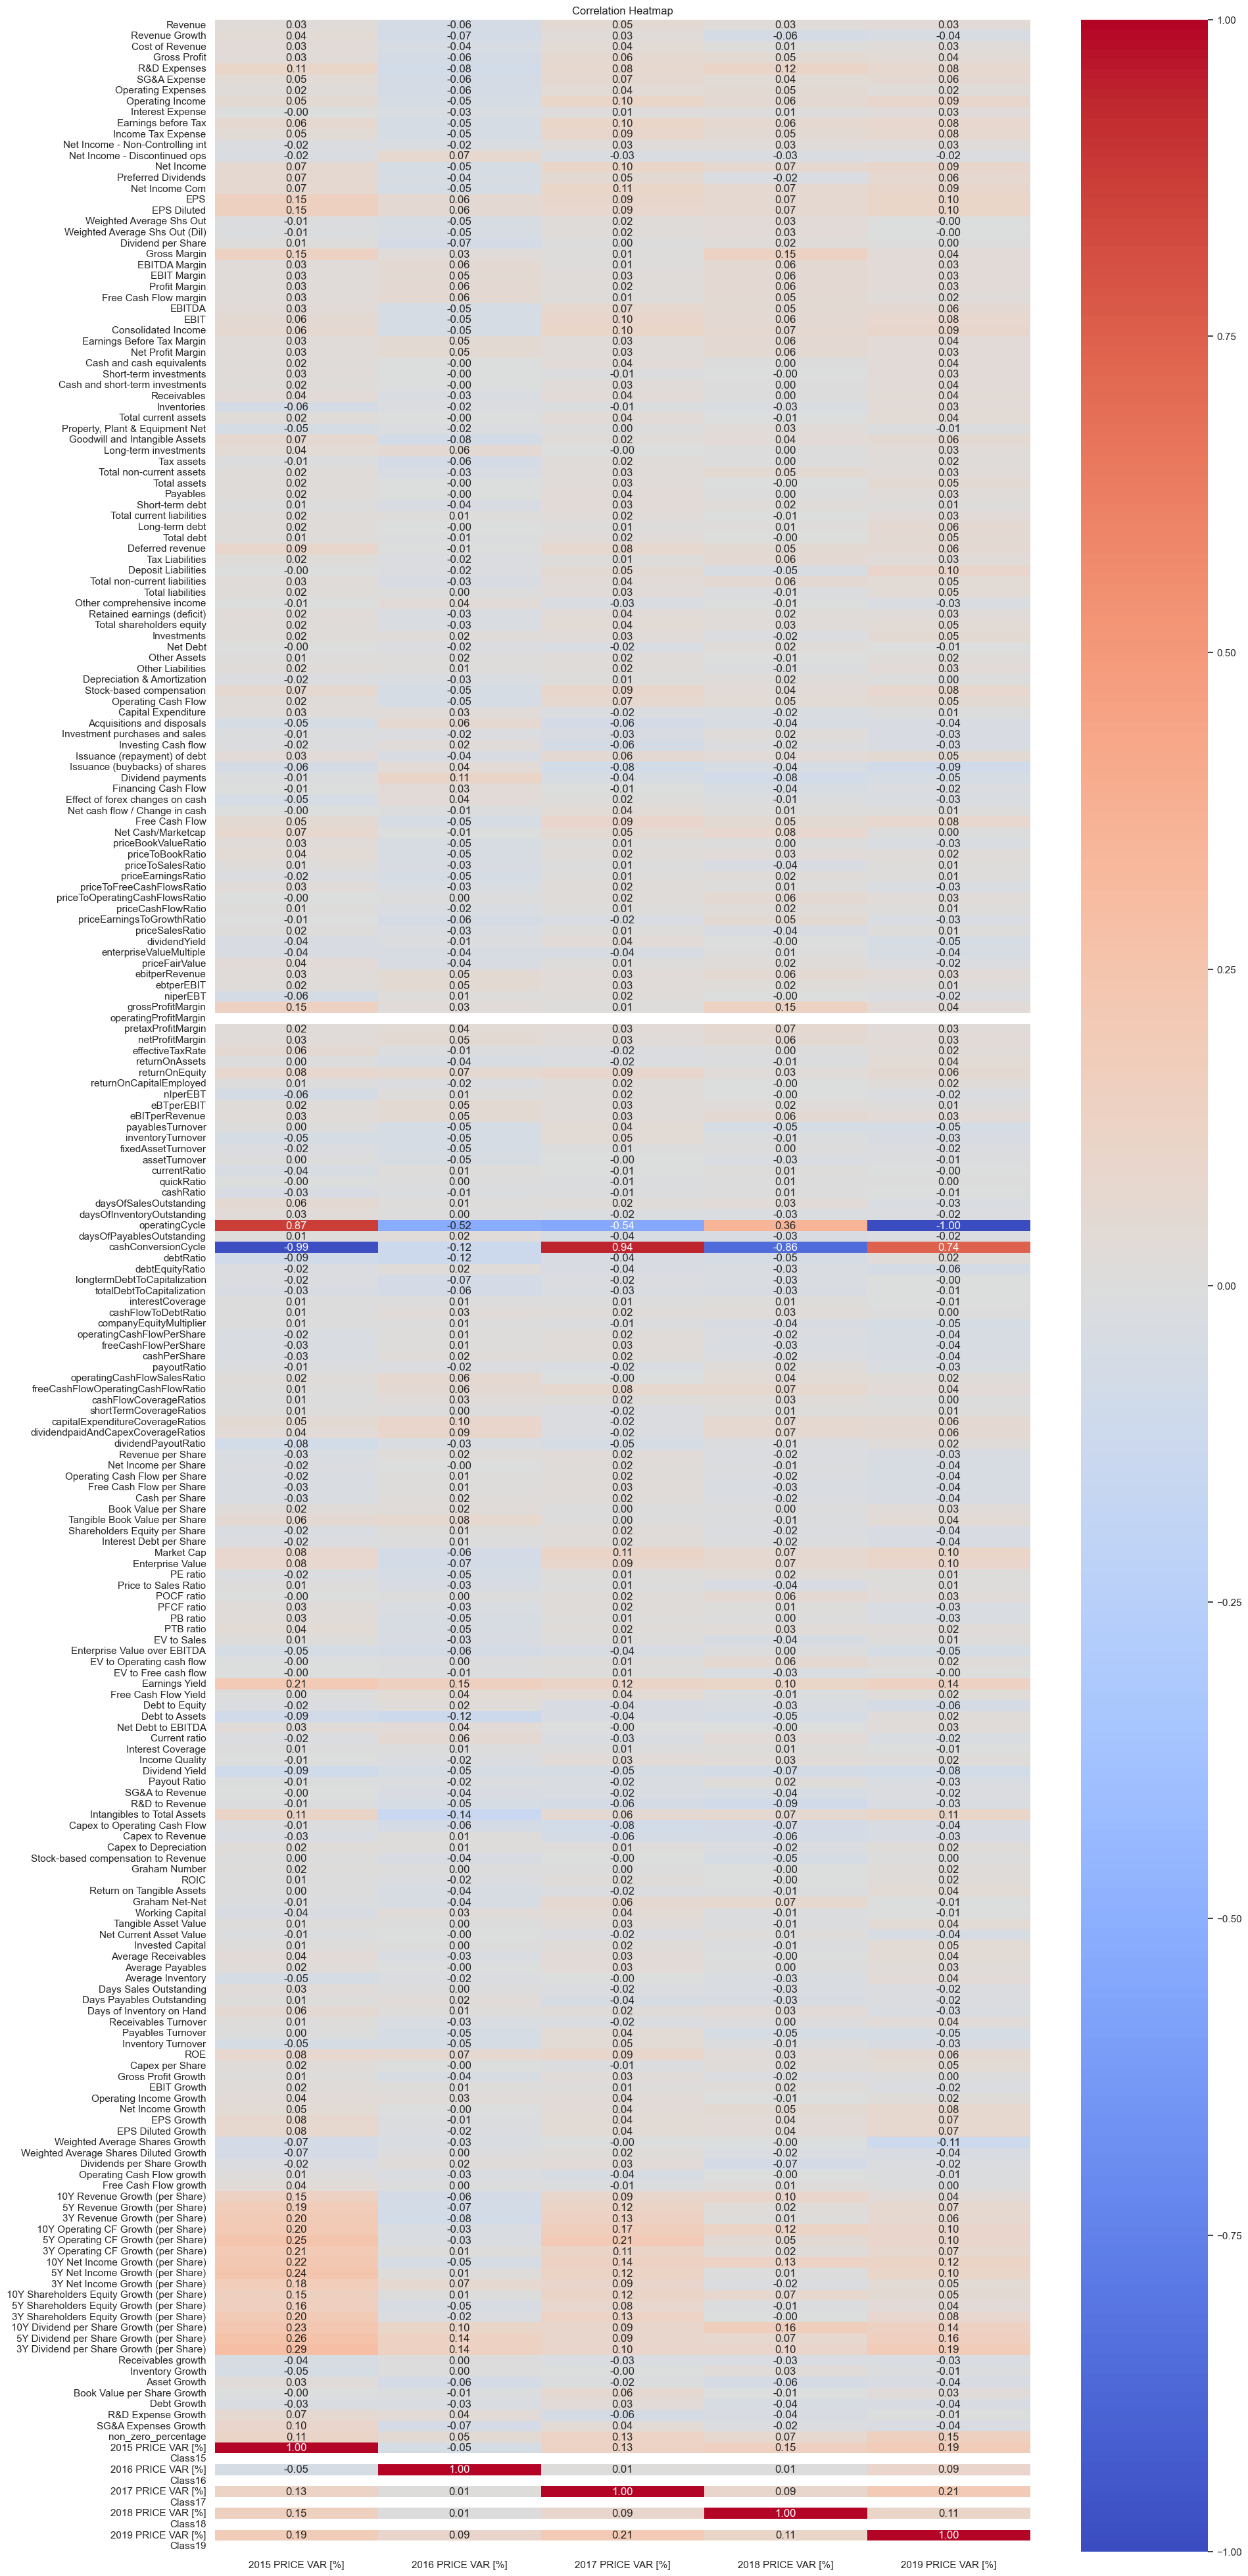

In [24]:
# Calculate the correlation matrix
corr_matrix = average_data_no_outliers.corr()

# Filter the correlation matrix to only show correlations with the stock price gains
price_var_corr = corr_matrix[['2015 PRICE VAR [%]', '2016 PRICE VAR [%]', '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]']]

# Create the heatmap
plt.figure(figsize=(20, 50))
sns.heatmap(price_var_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [25]:
# Find top correlated indicators for each year
num_top_indicators = 10
for year in range(2015, 2020):
    column = f'{year} PRICE VAR [%]'
    top_indicators = price_var_corr[column].apply(abs).sort_values(ascending=False).head(num_top_indicators + 1)
    top_indicators = top_indicators.drop(column)  # Remove the self-correlation
    print(f"Top {num_top_indicators} indicators for {year}:")
    print(top_indicators)
    print()

Top 10 indicators for 2015:
cashConversionCycle                          0.989516
operatingCycle                               0.868996
3Y Dividend per Share Growth (per Share)     0.292064
5Y Dividend per Share Growth (per Share)     0.262277
5Y Operating CF Growth (per Share)           0.253304
5Y Net Income Growth (per Share)             0.242339
10Y Dividend per Share Growth (per Share)    0.226776
10Y Net Income Growth (per Share)            0.224065
Earnings Yield                               0.209013
3Y Operating CF Growth (per Share)           0.206448
Name: 2015 PRICE VAR [%], dtype: float64

Top 10 indicators for 2016:
operatingCycle                               0.515992
Earnings Yield                               0.148755
Intangibles to Total Assets                  0.143168
3Y Dividend per Share Growth (per Share)     0.139445
5Y Dividend per Share Growth (per Share)     0.138145
cashConversionCycle                          0.120101
Debt to Assets                        

In [26]:
# Top 10 indicators for each year
top_10_2015 = {
    'cashConversionCycle': 0.989516,
    'operatingCycle': 0.868996,
    '3Y Dividend per Share Growth (per Share)': 0.292064,
    '5Y Dividend per Share Growth (per Share)': 0.262277,
    '5Y Operating CF Growth (per Share)': 0.253304,
    '5Y Net Income Growth (per Share)': 0.242339,
    '10Y Dividend per Share Growth (per Share)': 0.226776,
    '10Y Net Income Growth (per Share)': 0.224065,
    'Earnings Yield': 0.209013,
    '3Y Operating CF Growth (per Share)': 0.206448
}

top_10_2016 = {
    'operatingCycle': 0.515992,
    'Earnings Yield': 0.148755,
    'Intangibles to Total Assets': 0.143168,
    '3Y Dividend per Share Growth (per Share)': 0.139445,
    '5Y Dividend per Share Growth (per Share)': 0.138145,
    'cashConversionCycle': 0.120101,
    'Debt to Assets': 0.117404,
    'debtRatio': 0.117404,
    'Dividend payments': 0.114739,
    '10Y Dividend per Share Growth (per Share)': 0.103013
}

top_10_2017 = {
    'cashConversionCycle': 0.943411,
    'operatingCycle': 0.539811,
    '5Y Operating CF Growth (per Share)': 0.210161,
    '2019 PRICE VAR [%]': 0.207884,
    '10Y Operating CF Growth (per Share)': 0.170100,
    '10Y Net Income Growth (per Share)': 0.143564,
    '3Y Revenue Growth (per Share)': 0.134008,
    'non_zero_percentage': 0.128893,
    '3Y Shareholders Equity Growth (per Share)': 0.128653,
    '2015 PRICE VAR [%]': 0.127760
}

top_10_2018 = {
    'cashConversionCycle': 0.857330,
    'operatingCycle': 0.359286,
    '10Y Dividend per Share Growth (per Share)': 0.164992,
    '2015 PRICE VAR [%]': 0.149042,
    'grossProfitMargin': 0.147428,
    'Gross Margin': 0.147382,
    '10Y Net Income Growth (per Share)': 0.129802,
    '10Y Operating CF Growth (per Share)': 0.118993,
    'R&D Expenses': 0.115378,
    '2019 PRICE VAR [%]': 0.108070
}

top_10_2019 = {
    'operatingCycle': 0.997479,
    'cashConversionCycle': 0.742780,
    '2017 PRICE VAR [%]': 0.207884,
    '2015 PRICE VAR [%]': 0.193964,
    '3Y Dividend per Share Growth (per Share)': 0.191618,
    '5Y Dividend per Share Growth (per Share)': 0.159988,
    'non_zero_percentage': 0.153190,
    'Earnings Yield': 0.137300,
    '10Y Dividend per Share Growth (per Share)': 0.135599,
    '10Y Net Income Growth (per Share)': 0.121685
}



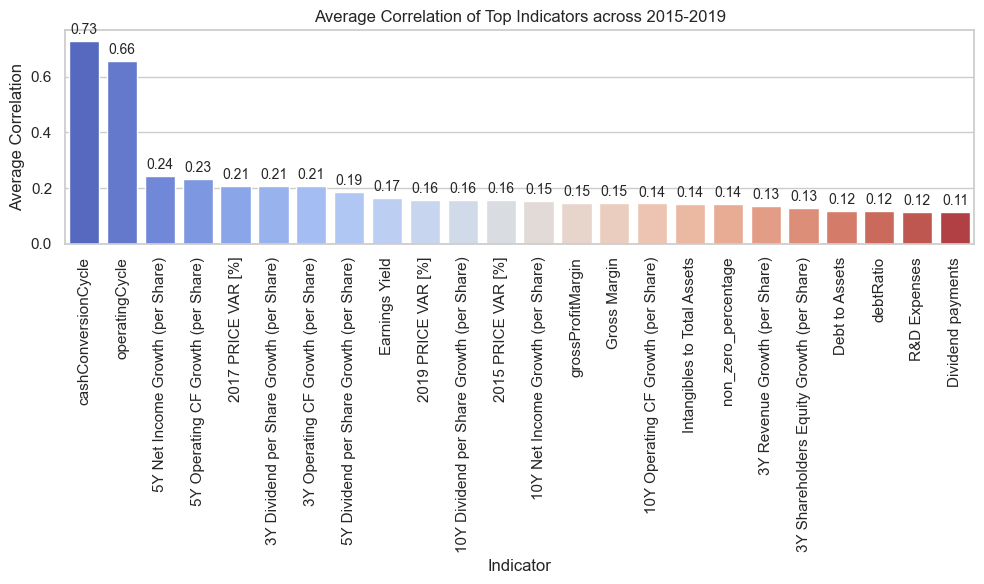

In [27]:
import seaborn as sns
from collections import defaultdict

# List of top indicators dictionaries for each year
top_indicators = [top_10_2015, top_10_2016, top_10_2017, top_10_2018, top_10_2019]

# Initialize the dictionaries
sum_correlations = defaultdict(float)
count_correlations = defaultdict(int)

# Iterate through the top indicators for each year
for yearly_indicators in top_indicators:
    for indicator, correlation in yearly_indicators.items():
        sum_correlations[indicator] += correlation
        count_correlations[indicator] += 1

# Calculate the average correlation for each indicator
average_correlations = {indicator: (sum_correlations[indicator] / count_correlations[indicator])
                        for indicator in sum_correlations}

# Sort the average correlations in descending order
sorted_average_correlations = dict(sorted(average_correlations.items(), key=lambda x: x[1], reverse=True))

# Set the Seaborn style for cool plots
sns.set(style='whitegrid')

# Plot the histogram
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(sorted_average_correlations.keys()), y=list(sorted_average_correlations.values()), palette='coolwarm')
plt.xticks(rotation=90)
plt.xlabel('Indicator')
plt.ylabel('Average Correlation')
plt.title('Average Correlation of Top Indicators across 2015-2019')

# Add the values on top of each bar
for p, value in zip(ax.patches, sorted_average_correlations.values()):
    ax.annotate(format(value, '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='baseline', xytext=(0, 5), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()



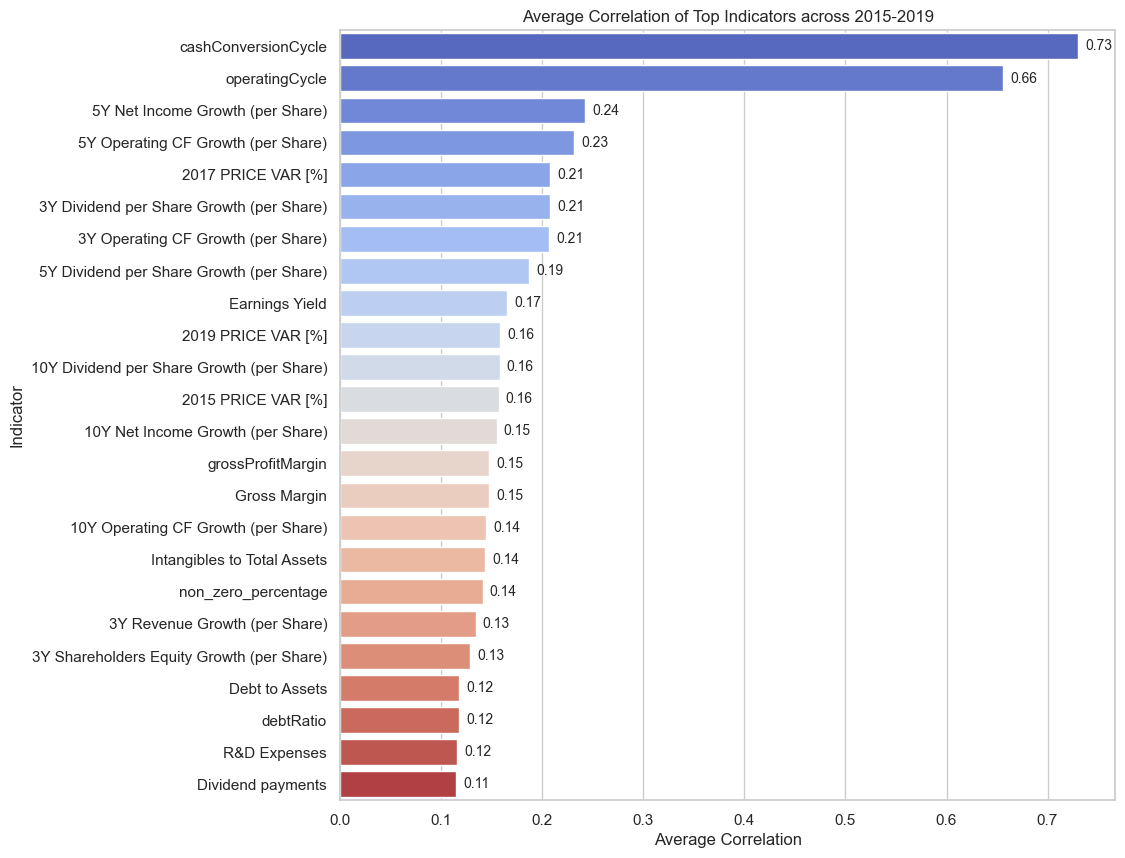

In [28]:
import seaborn as sns

# Set the Seaborn style for cool plots
sns.set(style='whitegrid')

# Plot the vertical bar chart
plt.figure(figsize=(10, 10))
ax = sns.barplot(y=list(sorted_average_correlations.keys()), x=list(sorted_average_correlations.values()), palette='coolwarm', orient='h')
plt.ylabel('Indicator')
plt.xlabel('Average Correlation')
plt.title('Average Correlation of Top Indicators across 2015-2019')

# Add the values on the right side of each bar
for p, value in zip(ax.patches, sorted_average_correlations.values()):
    ax.annotate(format(value, '.2f'), (p.get_width(), p.get_y() + p.get_height() / 2.),
                 ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=10)


plt.show()


In [29]:
# Combine all the top indicators from each year
combined_top_indicators = {}
for d in [top_10_2015, top_10_2016, top_10_2017, top_10_2018, top_10_2019]:
    combined_top_indicators.update(d)

# Calculate the average correlation for each indicator
average_correlations = {indicator: (sum_correlations[indicator] / count_correlations[indicator])
                        for indicator in combined_top_indicators}

# Sort the average correlations in descending order and take the top 10
sorted_average_correlations = dict(sorted(average_correlations.items(), key=lambda x: x[1], reverse=True)[:10])

# Display the top 10 indicators across all years
print("Top 10 Indicators across 2015-2019:")
for indicator, correlation in sorted_average_correlations.items():
    print(f"{indicator}: {correlation:.4f}")


Top 10 Indicators across 2015-2019:
cashConversionCycle: 0.7306
operatingCycle: 0.6563
5Y Net Income Growth (per Share): 0.2423
5Y Operating CF Growth (per Share): 0.2317
2017 PRICE VAR [%]: 0.2079
3Y Dividend per Share Growth (per Share): 0.2077
3Y Operating CF Growth (per Share): 0.2064
5Y Dividend per Share Growth (per Share): 0.1868
Earnings Yield: 0.1650
2019 PRICE VAR [%]: 0.1580


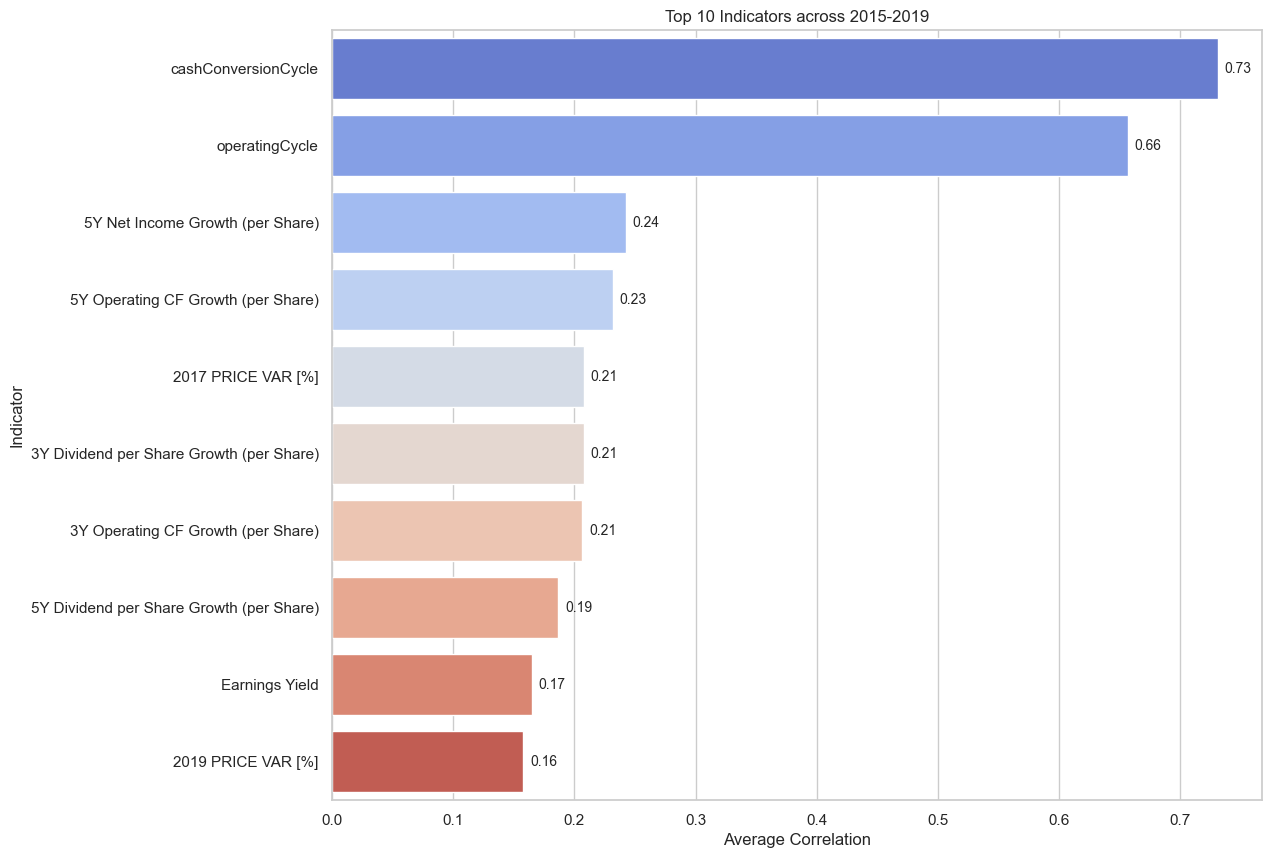

In [30]:
import seaborn as sns

# Set the Seaborn style for cool plots
sns.set(style='whitegrid')

# Plot the vertical bar chart
plt.figure(figsize=(12, 10))
ax = sns.barplot(y=list(sorted_average_correlations.keys()), x=list(sorted_average_correlations.values()), palette='coolwarm', orient='h')
plt.ylabel('Indicator')
plt.xlabel('Average Correlation')
plt.title('Top 10 Indicators across 2015-2019')

# Add the values on the right side of each bar
for p, value in zip(ax.patches, sorted_average_correlations.values()):
    ax.annotate(format(value, '.2f'), (p.get_width(), p.get_y() + p.get_height() / 2.),
                 ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=10)


plt.show()


In [31]:
# Exclude all 'Price Var%' indicators
filtered_correlations = {k: v for k, v in average_correlations.items() if 'PRICE VAR' not in k}

# Sort the filtered correlations in descending order and take the top 10
sorted_filtered_correlations = dict(sorted(filtered_correlations.items(), key=lambda x: x[1], reverse=True)[:10])

# Display the top 10 indicators across all years, excluding 'Price Var%' indicators
print("Top 10 Indicators across 2015-2019 (excluding 'Price Var%' indicators):")
for indicator, correlation in sorted_filtered_correlations.items():
    print(f"{indicator}: {correlation:.4f}")


Top 10 Indicators across 2015-2019 (excluding 'Price Var%' indicators):
cashConversionCycle: 0.7306
operatingCycle: 0.6563
5Y Net Income Growth (per Share): 0.2423
5Y Operating CF Growth (per Share): 0.2317
3Y Dividend per Share Growth (per Share): 0.2077
3Y Operating CF Growth (per Share): 0.2064
5Y Dividend per Share Growth (per Share): 0.1868
Earnings Yield: 0.1650
10Y Dividend per Share Growth (per Share): 0.1576
10Y Net Income Growth (per Share): 0.1548


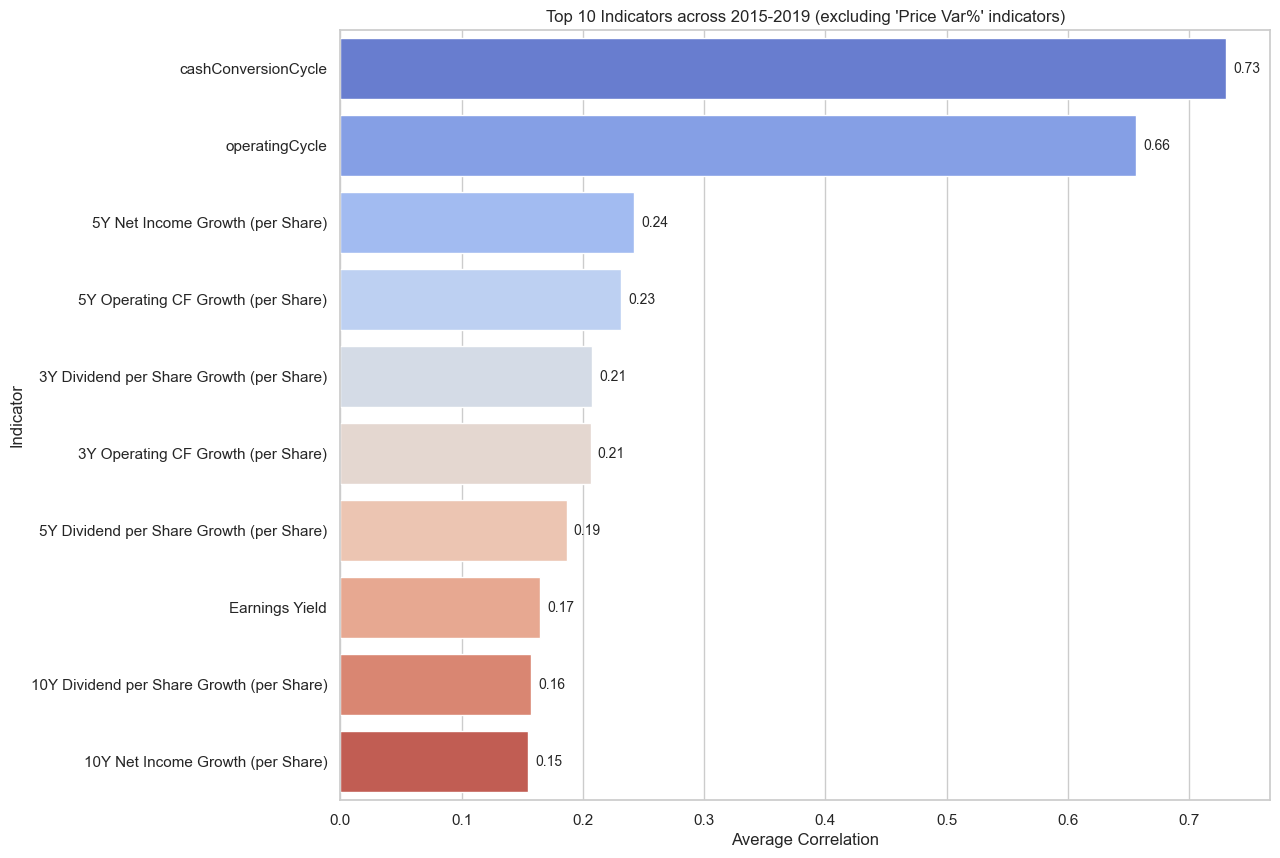

In [32]:
import seaborn as sns

# Set the Seaborn style for cool plots
sns.set(style='whitegrid')

# Plot the vertical bar chart
plt.figure(figsize=(12, 10))
ax = sns.barplot(y=list(sorted_filtered_correlations.keys()), x=list(sorted_filtered_correlations.values()), palette='coolwarm', orient='h')
plt.ylabel('Indicator')
plt.xlabel('Average Correlation')
plt.title("Top 10 Indicators across 2015-2019 (excluding 'Price Var%' indicators)")

# Add the values on the right side of each bar
for p, value in zip(ax.patches, sorted_filtered_correlations.values()):
    ax.annotate(format(value, '.2f'), (p.get_width(), p.get_y() + p.get_height() / 2.),
                 ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=10)


plt.show()


In [33]:
average_data_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2193 entries, 0 to 3767
Columns: 234 entries, Ticker to Class19
dtypes: float64(232), object(2)
memory usage: 3.9+ MB


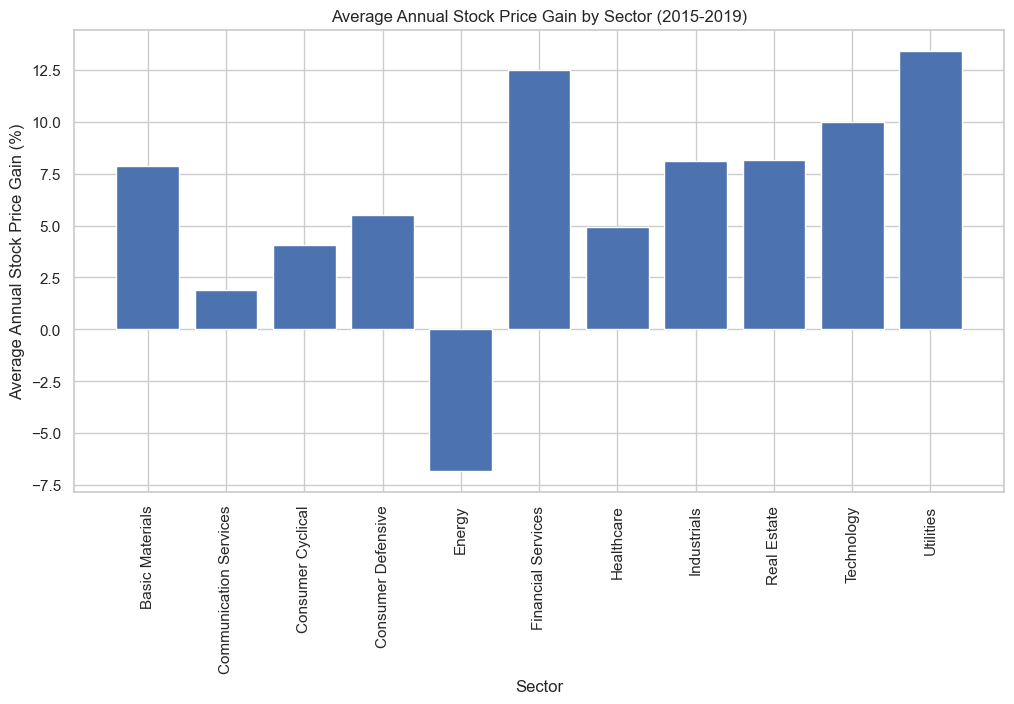

In [34]:
# Group the dataset by sector
sector_grouped = average_data_no_outliers.groupby('Sector')

# Calculate the average annual stock price gain for each sector
avg_annual_price_gain = sector_grouped[['2015 PRICE VAR [%]', '2016 PRICE VAR [%]', '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]']].mean()

# Calculate the average stock price gain across all years
avg_annual_price_gain['Average Gain'] = avg_annual_price_gain.mean(axis=1)

# Reset the index to make 'Sector' a column again
avg_annual_price_gain.reset_index(inplace=True)

# Visualize the sector trends using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(avg_annual_price_gain['Sector'], avg_annual_price_gain['Average Gain'])
plt.xticks(rotation=90)
plt.xlabel('Sector')
plt.ylabel('Average Annual Stock Price Gain (%)')
plt.title('Average Annual Stock Price Gain by Sector (2015-2019)')
plt.show()


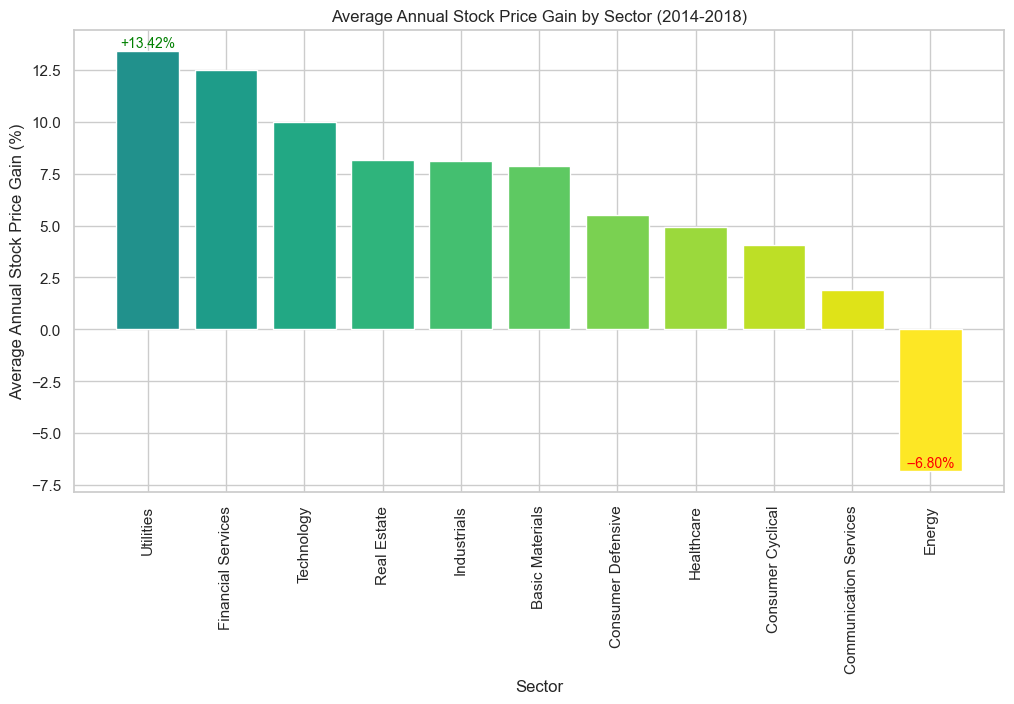

In [35]:
# Group the dataset by sector
sector_grouped = average_data_no_outliers.groupby('Sector')

# Calculate the average annual stock price gain for each sector
avg_annual_price_gain = sector_grouped[['2015 PRICE VAR [%]', '2016 PRICE VAR [%]', '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]']].mean()

# Calculate the average stock price gain across all years
avg_annual_price_gain['Average Gain'] = avg_annual_price_gain.mean(axis=1)

# Reset the index to make 'Sector' a column again
avg_annual_price_gain.reset_index(inplace=True)

# Sort the data by average gain
avg_annual_price_gain.sort_values(by='Average Gain', ascending=False, inplace=True)

# Generate gradient colors
colors = plt.cm.viridis(np.linspace(0.5, 1, len(avg_annual_price_gain)))

# Visualize the sector trends using a bar chart
plt.figure(figsize=(12, 6))
bar_plot = plt.bar(avg_annual_price_gain['Sector'], avg_annual_price_gain['Average Gain'], color=colors)
plt.xticks(rotation=90)
plt.xlabel('Sector')
plt.ylabel('Average Annual Stock Price Gain (%)')
plt.title('Average Annual Stock Price Gain by Sector (2014-2018)')

# Add labels for the highest and lowest bars
highest_value = avg_annual_price_gain['Average Gain'].max()
lowest_value = avg_annual_price_gain['Average Gain'].min()
highest_sector = avg_annual_price_gain.loc[avg_annual_price_gain['Average Gain'] == highest_value, 'Sector'].values[0]
lowest_sector = avg_annual_price_gain.loc[avg_annual_price_gain['Average Gain'] == lowest_value, 'Sector'].values[0]

plt.text(highest_sector, highest_value, f"+{highest_value:.2f}%", ha='center', va='bottom', fontsize=10, color='green')
plt.text(lowest_sector, lowest_value, f"-{lowest_value:.2f}%", ha='center', va='bottom', fontsize=10, color='red')

plt.show()


In [36]:
# Display the sorted average annual stock price gain data for each sector
avg_annual_price_gain[['Sector', 'Average Gain']].set_index('Sector').sort_values(by='Average Gain', ascending=False)


,Average Gain
Sector,
Utilities,13.424505
Financial Services,12.512458
Technology,9.986638
Real Estate,8.137030
Industrials,8.097553
Basic Materials,7.874552
Consumer Defensive,5.531269
Healthcare,4.920383
Consumer Cyclical,4.058374


In [37]:
top_performer_2015 = average_data_no_outliers.sort_values(by='2015 PRICE VAR [%]', ascending=False).groupby('Sector').first()

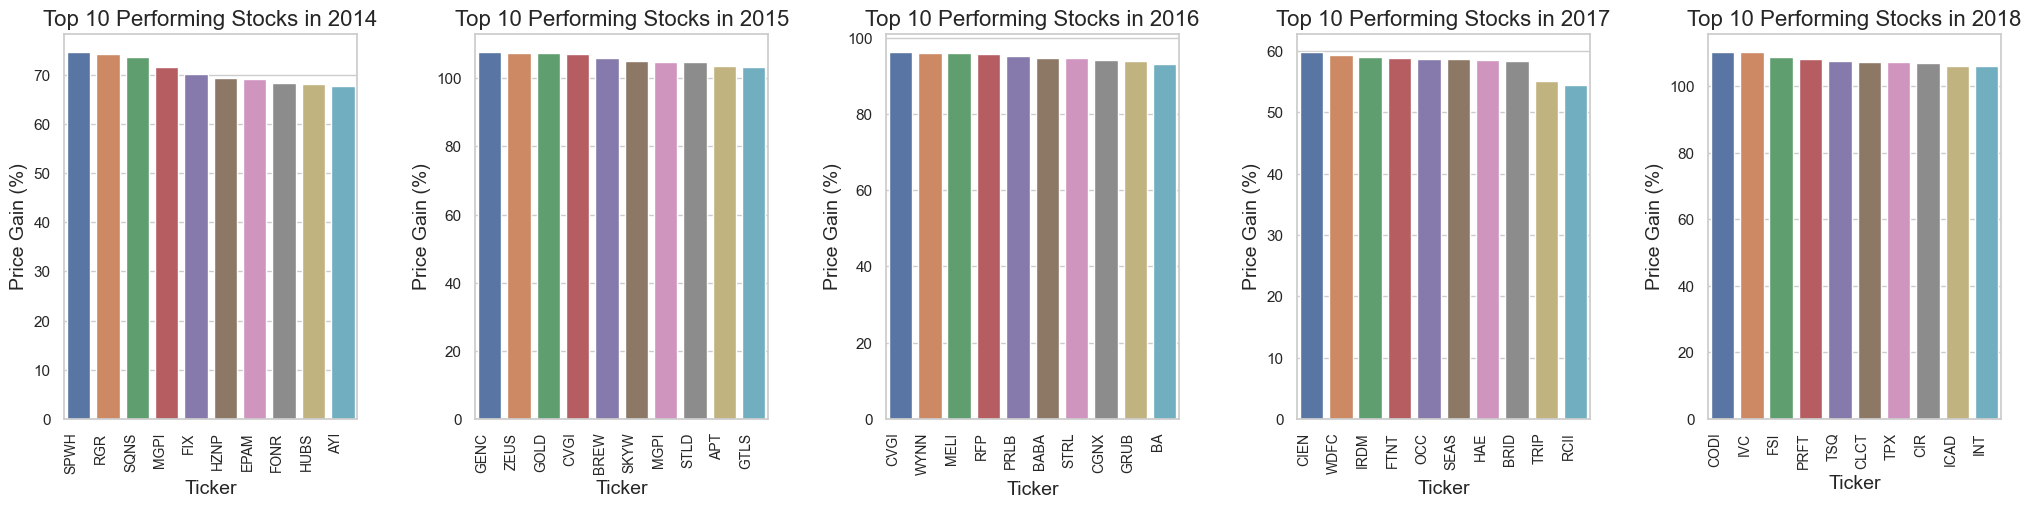

In [38]:
# Select the top 20 performing stocks in each year
top_20_2015 = average_data_no_outliers.nlargest(10, '2015 PRICE VAR [%]')
top_20_2016 = average_data_no_outliers.nlargest(10, '2016 PRICE VAR [%]')
top_20_2017 = average_data_no_outliers.nlargest(10, '2017 PRICE VAR [%]')
top_20_2018 = average_data_no_outliers.nlargest(10, '2018 PRICE VAR [%]')
top_20_2019 = average_data_no_outliers.nlargest(10, '2019 PRICE VAR [%]')

# Set the figure size
plt.figure(figsize=(25, 5))

# Plot the top 20 performing stocks in 2015
plt.subplot(151)
ax = sns.barplot(x='Ticker', y='2015 PRICE VAR [%]', data=top_20_2015)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.title('Top 10 Performing Stocks in 2014', fontsize=16)
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Price Gain (%)', fontsize=14)

# Plot the top 20 performing stocks in 2016
plt.subplot(152)
ax = sns.barplot(x='Ticker', y='2016 PRICE VAR [%]', data=top_20_2016)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.title('Top 10 Performing Stocks in 2015', fontsize=16)
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Price Gain (%)', fontsize=14)

# Plot the top 20 performing stocks in 2017
plt.subplot(153)
ax = sns.barplot(x='Ticker', y='2017 PRICE VAR [%]', data=top_20_2017)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.title('Top 10 Performing Stocks in 2016', fontsize=16)
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Price Gain (%)', fontsize=14)

# Plot the top 20 performing stocks in 2018
plt.subplot(154)
ax = sns.barplot(x='Ticker', y='2018 PRICE VAR [%]', data=top_20_2018)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.title('Top 10 Performing Stocks in 2017', fontsize=16)
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Price Gain (%)', fontsize=14)

# Plot the top 20 performing stocks in 2019
plt.subplot(155)
ax = sns.barplot(x='Ticker', y='2019 PRICE VAR [%]', data=top_20_2019)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)
plt.title('Top 10 Performing Stocks in 2018', fontsize=16)
plt.xlabel('Ticker', fontsize=14)
plt.ylabel('Price Gain (%)', fontsize=14)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()


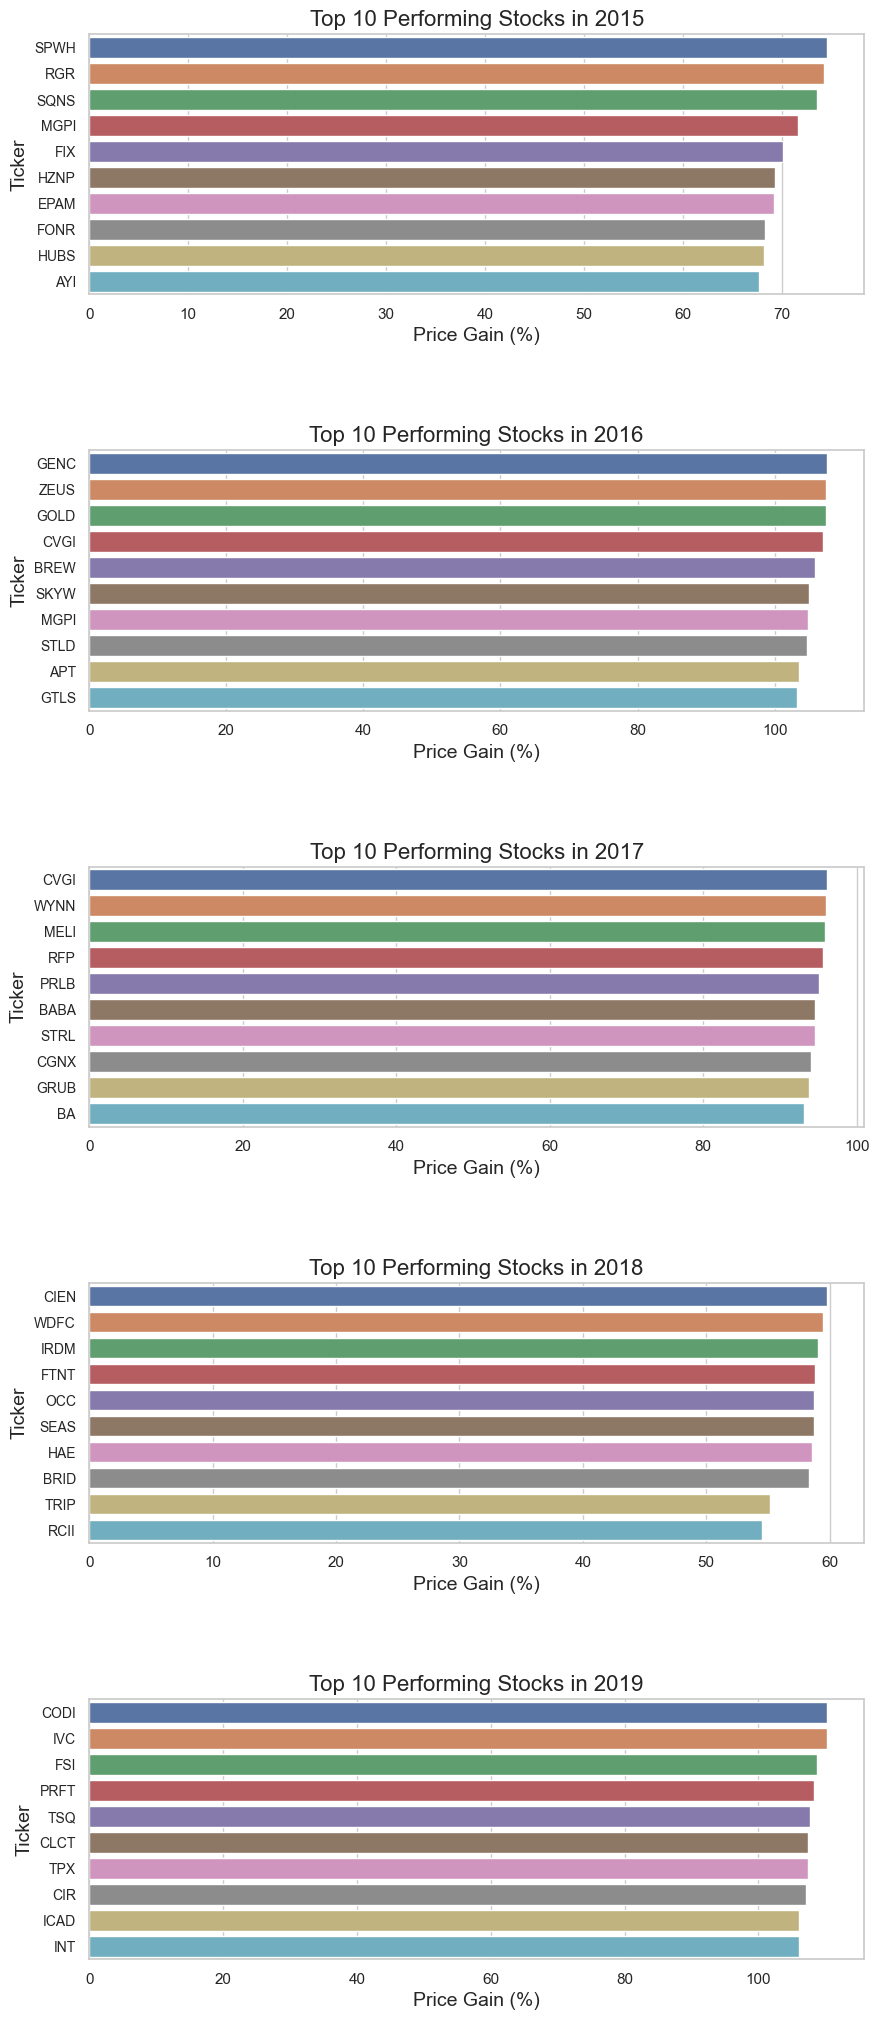

In [39]:
# Select the top 20 performing stocks in each year
top_20_2015 = average_data_no_outliers.nlargest(10, '2015 PRICE VAR [%]')
top_20_2016 = average_data_no_outliers.nlargest(10, '2016 PRICE VAR [%]')
top_20_2017 = average_data_no_outliers.nlargest(10, '2017 PRICE VAR [%]')
top_20_2018 = average_data_no_outliers.nlargest(10, '2018 PRICE VAR [%]')
top_20_2019 = average_data_no_outliers.nlargest(10, '2019 PRICE VAR [%]')

# Set the figure size
plt.figure(figsize=(10, 25))

# Plot the top 20 performing stocks in 2015
plt.subplot(511)
ax = sns.barplot(x='2015 PRICE VAR [%]', y='Ticker', data=top_20_2015)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 10 Performing Stocks in 2015', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Plot the top 20 performing stocks in 2016
plt.subplot(512)
ax = sns.barplot(x='2016 PRICE VAR [%]', y='Ticker', data=top_20_2016)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 10 Performing Stocks in 2016', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Plot the top 20 performing stocks in 2017
plt.subplot(513)
ax = sns.barplot(x='2017 PRICE VAR [%]', y='Ticker', data=top_20_2017)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 10 Performing Stocks in 2017', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Plot the top 20 performing stocks in 2018
plt.subplot(514)
ax = sns.barplot(x='2018 PRICE VAR [%]', y='Ticker', data=top_20_2018)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 10 Performing Stocks in 2018', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Plot the top 20 performing stocks in 2019
plt.subplot(515)
ax = sns.barplot(x='2019 PRICE VAR [%]', y='Ticker', data=top_20_2019)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 10 Performing Stocks in 2019', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.6)

# Show the plot
plt.show()


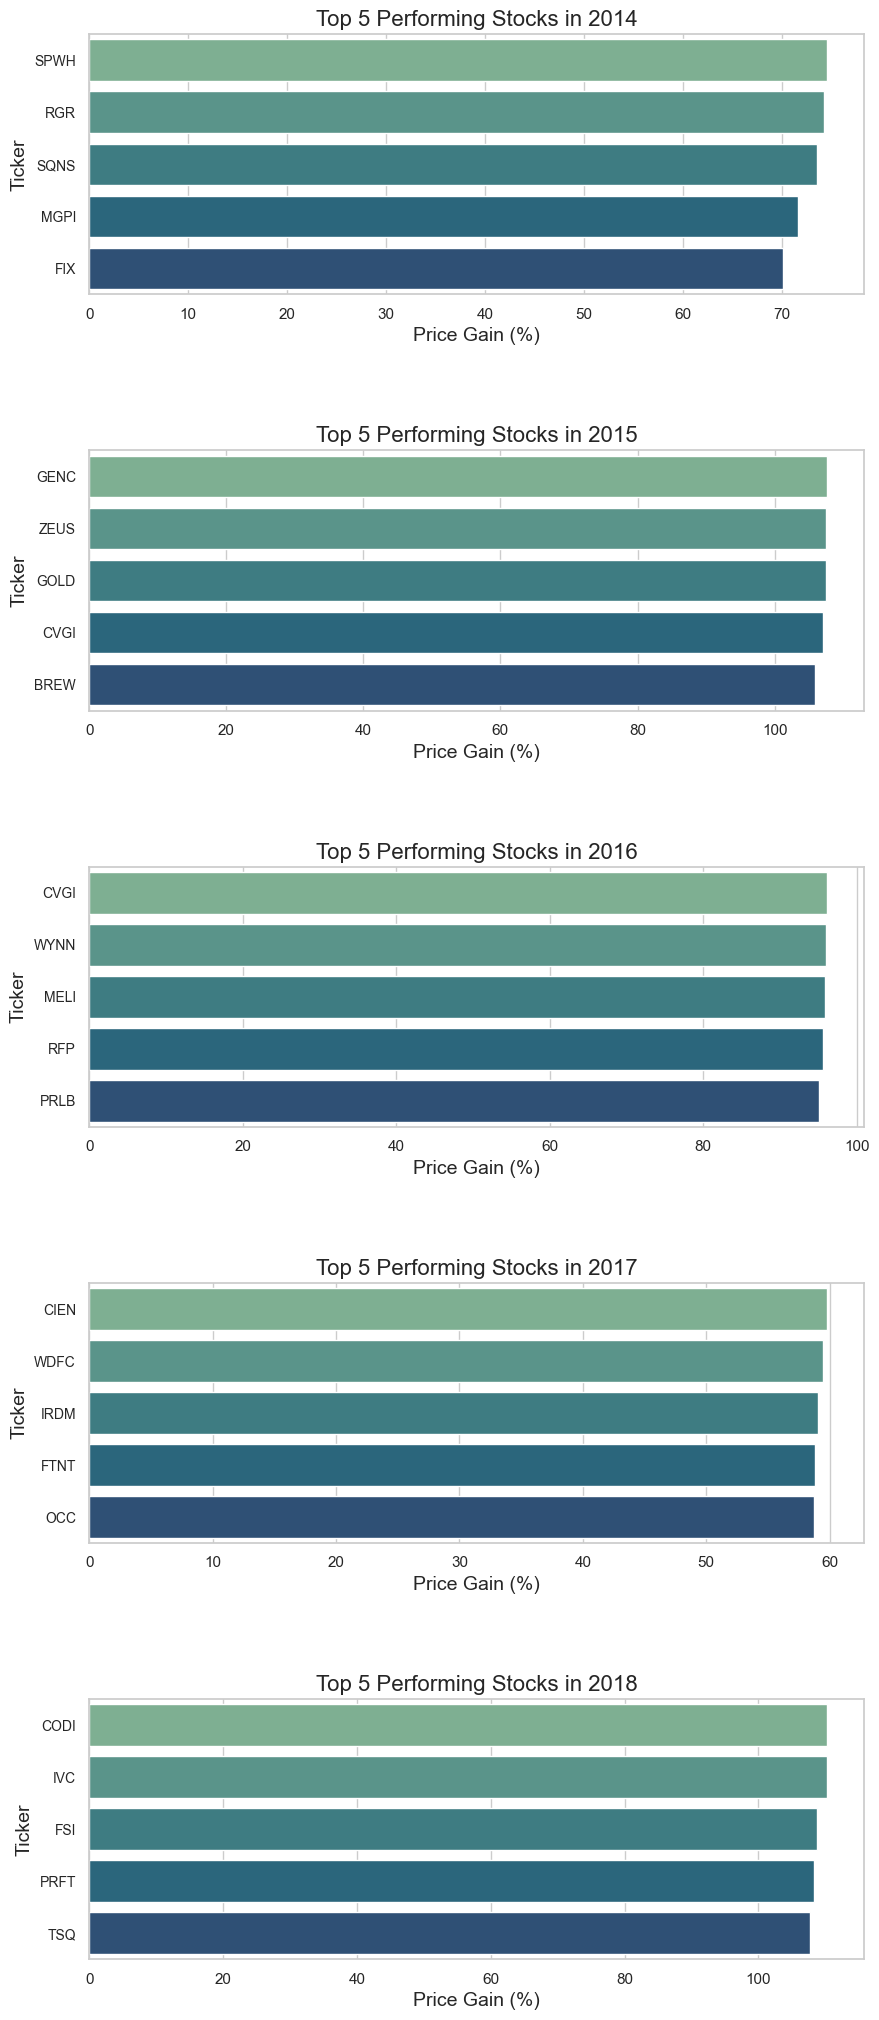

In [40]:
# Set the color palette
palette = sns.color_palette("crest", 5)

# Plot the top 20 performing stocks in each year
top_20_2015 = average_data_no_outliers.nlargest(5, '2015 PRICE VAR [%]')
top_20_2016 = average_data_no_outliers.nlargest(5, '2016 PRICE VAR [%]')
top_20_2017 = average_data_no_outliers.nlargest(5, '2017 PRICE VAR [%]')
top_20_2018 = average_data_no_outliers.nlargest(5, '2018 PRICE VAR [%]')
top_20_2019 = average_data_no_outliers.nlargest(5, '2019 PRICE VAR [%]')

# Set the figure size
plt.figure(figsize=(10, 25))

# Plot the top 20 performing stocks in 2015
plt.subplot(511)
ax = sns.barplot(x='2015 PRICE VAR [%]', y='Ticker', data=top_20_2015, palette=palette)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 5 Performing Stocks in 2014', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Plot the top 20 performing stocks in 2016
plt.subplot(512)
ax = sns.barplot(x='2016 PRICE VAR [%]', y='Ticker', data=top_20_2016, palette=palette)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 5 Performing Stocks in 2015', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Plot the top 20 performing stocks in 2017
plt.subplot(513)
ax = sns.barplot(x='2017 PRICE VAR [%]', y='Ticker', data=top_20_2017, palette=palette)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 5 Performing Stocks in 2016', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Plot the top 20 performing stocks in 2018
plt.subplot(514)
ax = sns.barplot(x='2018 PRICE VAR [%]', y='Ticker', data=top_20_2018, palette=palette)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 5 Performing Stocks in 2017', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Plot the top 20 performing stocks in 2019
plt.subplot(515)
ax = sns.barplot(x='2019 PRICE VAR [%]', y='Ticker', data=top_20_2019, palette=palette)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 5 Performing Stocks in 2018', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.6)

# Show the plot
plt.show()


In [42]:
# Create a new column to store the sum of price var for each stock
average_data_no_outliers['PRICE VAR [%]'] = 0

# Iterate over the rows in the dataframe
for i, row in average_data_no_outliers.iterrows():
    # Get the price var for each year and sum them up
    price_var_sum = sum(row[['2015 PRICE VAR [%]', '2016 PRICE VAR [%]', '2017 PRICE VAR [%]', '2018 PRICE VAR [%]', '2019 PRICE VAR [%]']])
    
    # Update the 'PRICE VAR [%]' column with the total price var
    average_data_no_outliers.at[i, 'PRICE VAR [%]'] = price_var_sum


In [43]:
average_data_no_outliers.head()

,Ticker,Sector,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,...,Class15,2016 PRICE VAR [%],Class16,2017 PRICE VAR [%],Class17,2018 PRICE VAR [%],Class18,2019 PRICE VAR [%],Class19,PRICE VAR [%]
0,A,Healthcare,4.334800e+09,0.04814,2.072800e+09,2.262000e+09,348200000.0,1.248800e+09,1.597000e+09,6.650000e+08,...,1.0,13.194947,1.0,45.350940,1.0,0.717881,1.0,30.976102,1.0,94.419114
2,AAL,Industrials,4.218900e+10,0.12840,1.863500e+10,2.355400e+10,NaN,1.209240e+10,1.907400e+10,4.480000e+09,...,1.0,15.404948,1.0,13.344850,1.0,-38.817936,1.0,-10.602069,1.0,-41.438304
3,AAME,Financial Services,1.730004e+08,0.02386,1.121842e+08,6.081620e+07,NaN,4.228860e+07,5.544040e+07,5.375800e+06,...,1.0,-14.942088,1.0,-16.654341,1.0,-25.389821,1.0,-20.250605,1.0,-52.791741
4,AAN,Industrials,3.259027e+09,0.11624,2.951072e+08,2.963920e+09,NaN,1.392605e+09,2.730039e+09,2.338810e+08,...,1.0,41.604419,1.0,25.314724,1.0,6.825130,1.0,31.675678,1.0,78.770156
5,AAOI,Technology,2.461718e+08,0.33164,1.570306e+08,8.914120e+07,30774000.0,3.480920e+07,6.558320e+07,2.355800e+07,...,1.0,43.891953,1.0,63.722940,1.0,-59.298337,1.0,-25.188917,1.0,82.163783


Text(0, 0.5, 'Ticker')

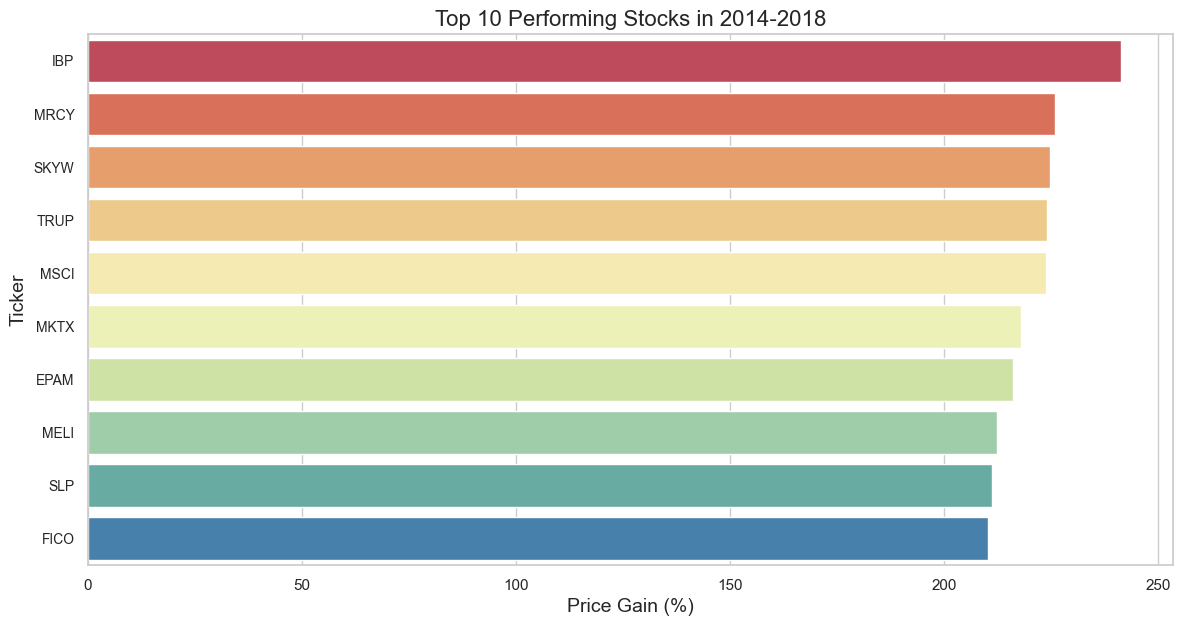

In [59]:
# Set the color palette
palette = sns.color_palette("Spectral", 10)

# Plot the top 20 performing stocks in each year
top_20_2015 = average_data_no_outliers.nlargest(10, 'PRICE VAR [%]')


# Set the figure size
plt.figure(figsize=(14, 40))

# Plot the top 20 performing stocks in 2015
plt.subplot(511)
ax = sns.barplot(x='PRICE VAR [%]', y='Ticker', data=top_20_2015, palette=palette)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title('Top 10 Performing Stocks in 2014-2018', fontsize=16)
plt.xlabel('Price Gain (%)', fontsize=14)
plt.ylabel('Ticker', fontsize=14)